## Calculate Sunyaev-Zeldovich effect

This is an example notebook to familiarise you with the ntsz Python package. It is developed to enable you to compute the distortion in the specific intensity of the Cosmic Microwave Background (CMB) due to the non-thermal Sunyaev-Zeldovich (ntSZ) effect. It has functionalities to also apply bandpass corrections when one wants to estimate observed spectra considering Planck satellite's detectors. For more information on the theory, I refer you to [Ensslin & Kaiser (2000)](https://arxiv.org/abs/astro-ph/0001429) and the references therein.

In this notebook, we shall look at how to use the package:
1) to compute thermal SZ (tSZ), tSZ with relativistic corrections (rSZ), non-thermal SZ
 (ntSZ) and kinetic SZ (kSZ) effects
2) Plot the computed spectra

In [2]:
# import necessary packages and a few constants
import numpy as np
import ntsz as nt
from astropy.constants import m_e, k_B, c, h
import matplotlib.pyplot as plt

# Define constants
c = c.si.value
m_e = m_e.si.value
h = h.si.value
k_B = k_B.si.value
T_CMB = 2.7255  # K

Inverse-Compton (IC) scattering of CMB photons by energetic electrons is known as Sunyaev-Zeldovich (SZ) effect. It causes a frequency-dependent distortion in the specific intensity of CMB. The total SZ effect is a composite of different components that can be written as (for a detailed description of the variables, refer to [Vyoma Muralidhara & Kaustuv Basu (2024)](https://iopscience.iop.org/article/10.1088/1475-7516/2024/11/010/meta)):

$\Delta i(x) = \underbrace{g_\mathrm{th}(x) y_\mathrm{th}}_{\mathrm{thermal\: SZ}} - \underbrace{k(x)\beta_e\tau_e}_{\mathrm{kinetic \: SZ}} + \underbrace{g_\mathrm{nth}(x)y_\mathrm{nth}}_{\mathrm{nonthermal \: SZ}}$

where $x = \frac{h \nu}{k_\mathrm{B} T_\mathrm{CMB}}$.

For a general distribution of scattering electrons, we can write

$ g(x) = \Big[h(x) - i(x)\Big]\frac{m_ec^2}{k_B\tilde{T}_e}$,

where
$ h(x) = \int_0^\infty \int_{-\infty}^{\infty} P(e^s;p)e^s\:[i(x/e^s)]\:f_e(p)\:\mathrm{d}s\:\mathrm{d}p$,

and $i(x)$ is the Planck function.

To estimate each component of the total SZ effect, we need to consider an appropriate momentum distribution, $f_e(p)$, describing the scattering electrons. For the examples below, we consider the Maxwell-Juettner equation for the scattering electrons of temperature $T_e$ in keV and a power-law distribution of scattering electrons to estimate non-thermal SZ spectrum. The functions within the ntsz package compute $h(x)$ from which we then subtract $i(x)$ and multiply by the Compton-$y$ parameter.


In [ ]:
class params:
    # let's define the power-law describing the momentum distribution of the scattering electrons
    alpha = 3.6 # spectral index of the power-law. It's made negative inside the functions.
    pmin = 1.0
    pmax = 5e5
    temp = 5 # kinetic temp. in keV of scattering thermal population of electrons
    i0 = 2 * (k_B * T_CMB) ** 3 / (h * c) ** 2 * 1e20
    
# specify a range of observing frequencies
f = np.linspace(10, 800, 50, dtype=np.float32)*1e9 # in Hz
xf = nt.freq_to_x(f) # normalized frequency

# define variables to store the estimated spectra
ntsz_spec = np.zeros(f.shape[0], dtype=np.float32)
tsz_spec = np.zeros(f.shape[0], dtype=np.float32)
ksz_spec = np.zeros(f.shape[0], dtype=np.float32)

# Compute the spectra
for i in np.arange(f.shape[0]):
    ntsz_spec[i] = nt.powerlaw_int(alpha=params.alpha, pmin=params.pmin, pmax=params.pmax, x=xf[i])\
    - nt.i_x(xf[i]) * params.i0
    tsz_spec[i] = (nt.thermal_int(pmin=1e-8, pmax=0.9, x=xf[i], t=params.temp)
                    - nt.i_x(xf[i])) * params.i0

/home/vyoma/code/ntsz/src/ntsz.py:113: RuntimeWarning: overflow encountered in exp
  func = func * ((x / t[i]) ** 3 / (np.exp(x / t[i]) - 1))


/tmp/ipykernel_33367/3527382246.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(np.round(nt.x_to_freq(ax1_ticks), 1))


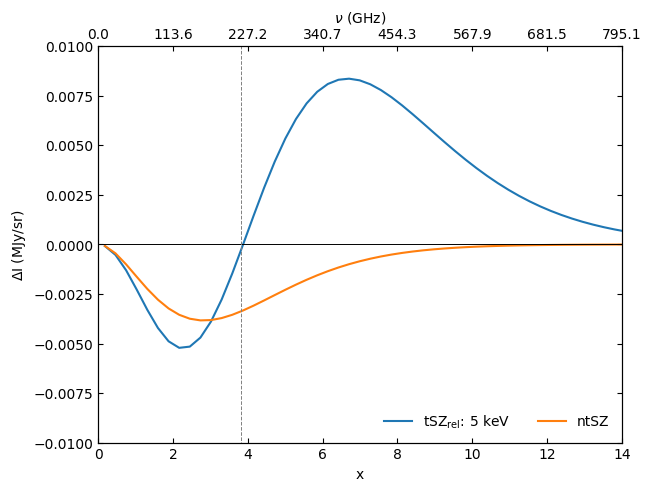

In [3]:
# Plot the estimated spectra with dimensionless frequency x on bottom x-axis 
# and frequency in GHz on top x-axis
# Grey dashed line indicates the crossover frequency of tSZ effect at 217 GHz
fig, ax1 = plt.subplots(constrained_layout=True)
ax1.plot(xf, tsz_spec*5e-4, label=r'tSZ$_{\mathrm{rel}}$: 5 keV')
ax1.plot(xf, ntsz_spec*1e-5, label='ntSZ')
ax1.plot([0,17.0],[0,0], '-', color='k', lw=0.7)
ax1.plot([3.821,3.821], [-0.015,0.020], '--', lw=0.7, color='grey')
ax1.legend(loc="lower right", ncol=2,frameon=False, markerfirst=True,prop={'size': 10})
ax1.set_ylabel(r"$\Delta$I (MJy/sr)")
ax1.set_xlabel("x")
ax1.set_xlim(0,14.0)
ax1.set_ylim(-0.01,0.01)
ax2 = ax1.twiny()
ax1_ticks = np.arange(0,16,2)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticklabels(np.round(nt.x_to_freq(ax1_ticks), 1))
ax2.set_xticks(ax1_ticks)
ax2.set_xlabel(r'$\nu$ (GHz)')
ax1.tick_params(axis='both', direction='in', which='both', bottom=True, top=False, right=True, left=True)
ax2.tick_params(axis='x', direction='in', which='both', bottom=False, top=True, right=False, left=False)

### Interpolated ntSZ spectra

In cases where we want to fix the index and $p_\mathrm{max}$ but vary $p_\mathrm{min}$ (or $p_\mathrm{break}$ in the case of a broken power-law), we can use the interpolated ntSZ spectra.

A grid with pre-computed $g_\mathrm{nth}(x)$ as a function of $p_\mathrm{min}$ ($p_\mathrm{break}$) and $x$ is provided for a single (broken) power-law models with this package. One can then use interpolation to estimate the ntSZ as a function of pmin for single power-law models or as a function of pbreak for broken power-law models.

The fixed parameters when using the pre-computed grids for ntSZ spectra generated by scattering electrons described by a single power-law are:

$\alpha$ (index) $= -3.61$;

$p_\mathrm{max}$ = $5\times 10^5$

The fixed parameters when using the pre-computed grids for ntSZ spectra generated by scattering electrons described by a broken power-law are:

$\alpha_1$ (index of the flat part) $= 0.05$;

$\alpha_2$ (index of the power-law) $= -3.61$;

$p_\mathrm{max}$ = $5\times 10^5$


In [4]:
# Let us consider the following values for the minimum momenta to estimate ntsz with electrons
# described by single power-law
pmin = np.array([10, 100, 300], dtype=np.float32)

# Let us consider the following values for the break momenta to estimate ntsz with electrons
# described by broken power-law
pbreak = np.array([100, 300, 600], dtype=np.float32)

# Choose variables to store the estimated spectra
ntsz_single = np.zeros((pmin.shape[0], f.shape[0]), dtype=np.float32)
ntsz_broken = np.zeros((pbreak.shape[0], f.shape[0]), dtype=np.float32)

for i in np.arange(pmin.shape[0]):
    ntsz_single[i] = nt.ntsz_single_interpol(pmin=pmin[i], freq=f/1e9, path_to_grid=None)
    ntsz_broken[i] = nt.ntsz_broken_interpol(pbreak=pbreak[i], freq=f/1e9, path_to_grid=None)

/home/vyoma/code/ntsz/src/ntsz.py:332: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(func, 0, x, args=(a, b))[0]


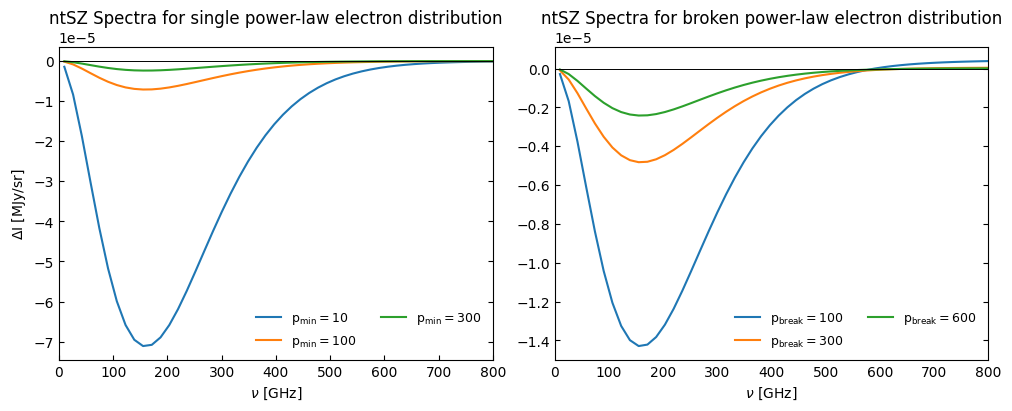

In [16]:
# Plot the spectra
# We shall consider y_nth = 1e-6 for both single and broken power-law cases
ynth = 1e-6
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, constrained_layout=True)
fig.figure.set_size_inches(10,4)
for i in np.arange(pmin.shape[0]):
    ax1.plot(f/1e9, ntsz_single[i]*ynth, label=r'$\mathrm{p_{min}=%d}$' % (pmin[i]))
    ax2.plot(f/1e9, ntsz_broken[i]*ynth, label=r'$\mathrm{p_{break}=%d}$' % (pbreak[i]))
ax1.plot([0,800],[0,0], '-', color='k', lw=0.7)
ax1.legend(loc="lower right", ncol=2,frameon=False, markerfirst=True,prop={'size': 9})
ax2.plot([0,800],[0,0], '-', color='k', lw=0.7)
ax2.legend(loc="lower right", ncol=2,frameon=False, markerfirst=True,prop={'size': 9})
ax1.set_ylabel(r"$\Delta$I [MJy/sr]")
ax1.set_xlim(0,800)
ax2.set_xlim(0,800)
ax1.set_ylabel(r"$\Delta$I [MJy/sr]")
ax1.set_xlabel(r'$\nu$ [GHz]')
ax2.set_xlabel(r'$\nu$ [GHz]')
ax1.set_title('ntSZ Spectra for single power-law electron distribution')
ax2.set_title('ntSZ Spectra for broken power-law electron distribution')
ax1.tick_params(axis='both', direction='in', which='both', bottom=True, top=False, right=True, left=True)
ax2.tick_params(axis='both', direction='in', which='both', bottom=False, top=False, right=True, left=True)

In order to understand this strong sensitivity of the spectra on $p_\mathrm{min}$ (or $p_\mathrm{max}$), the user is referred to [Vyoma Muralidhara & Kaustuv Basu (2024)](https://iopscience.iop.org/article/10.1088/1475-7516/2024/11/010/meta) and the references therein.